/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_24536/551454388.py:91: RuntimeWarning: invalid value encountered in divide
  mean_vr = vr_sum / count
/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_24536/551454388.py:92: RuntimeWarning: invalid value encountered in divide
  sigma2_r = vr2_sum / count - mean_vr**2
/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_24536/551454388.py:93: RuntimeWarning: invalid value encountered in sqrt
  sigma_r = np.sqrt(sigma2_r)
/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_24536/551454388.py:97: RuntimeWarning: divide by zero encountered in divide
  Q = rho / sigma_r**3
/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_24536/551454388.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right", fontsize=8, frameon=False)


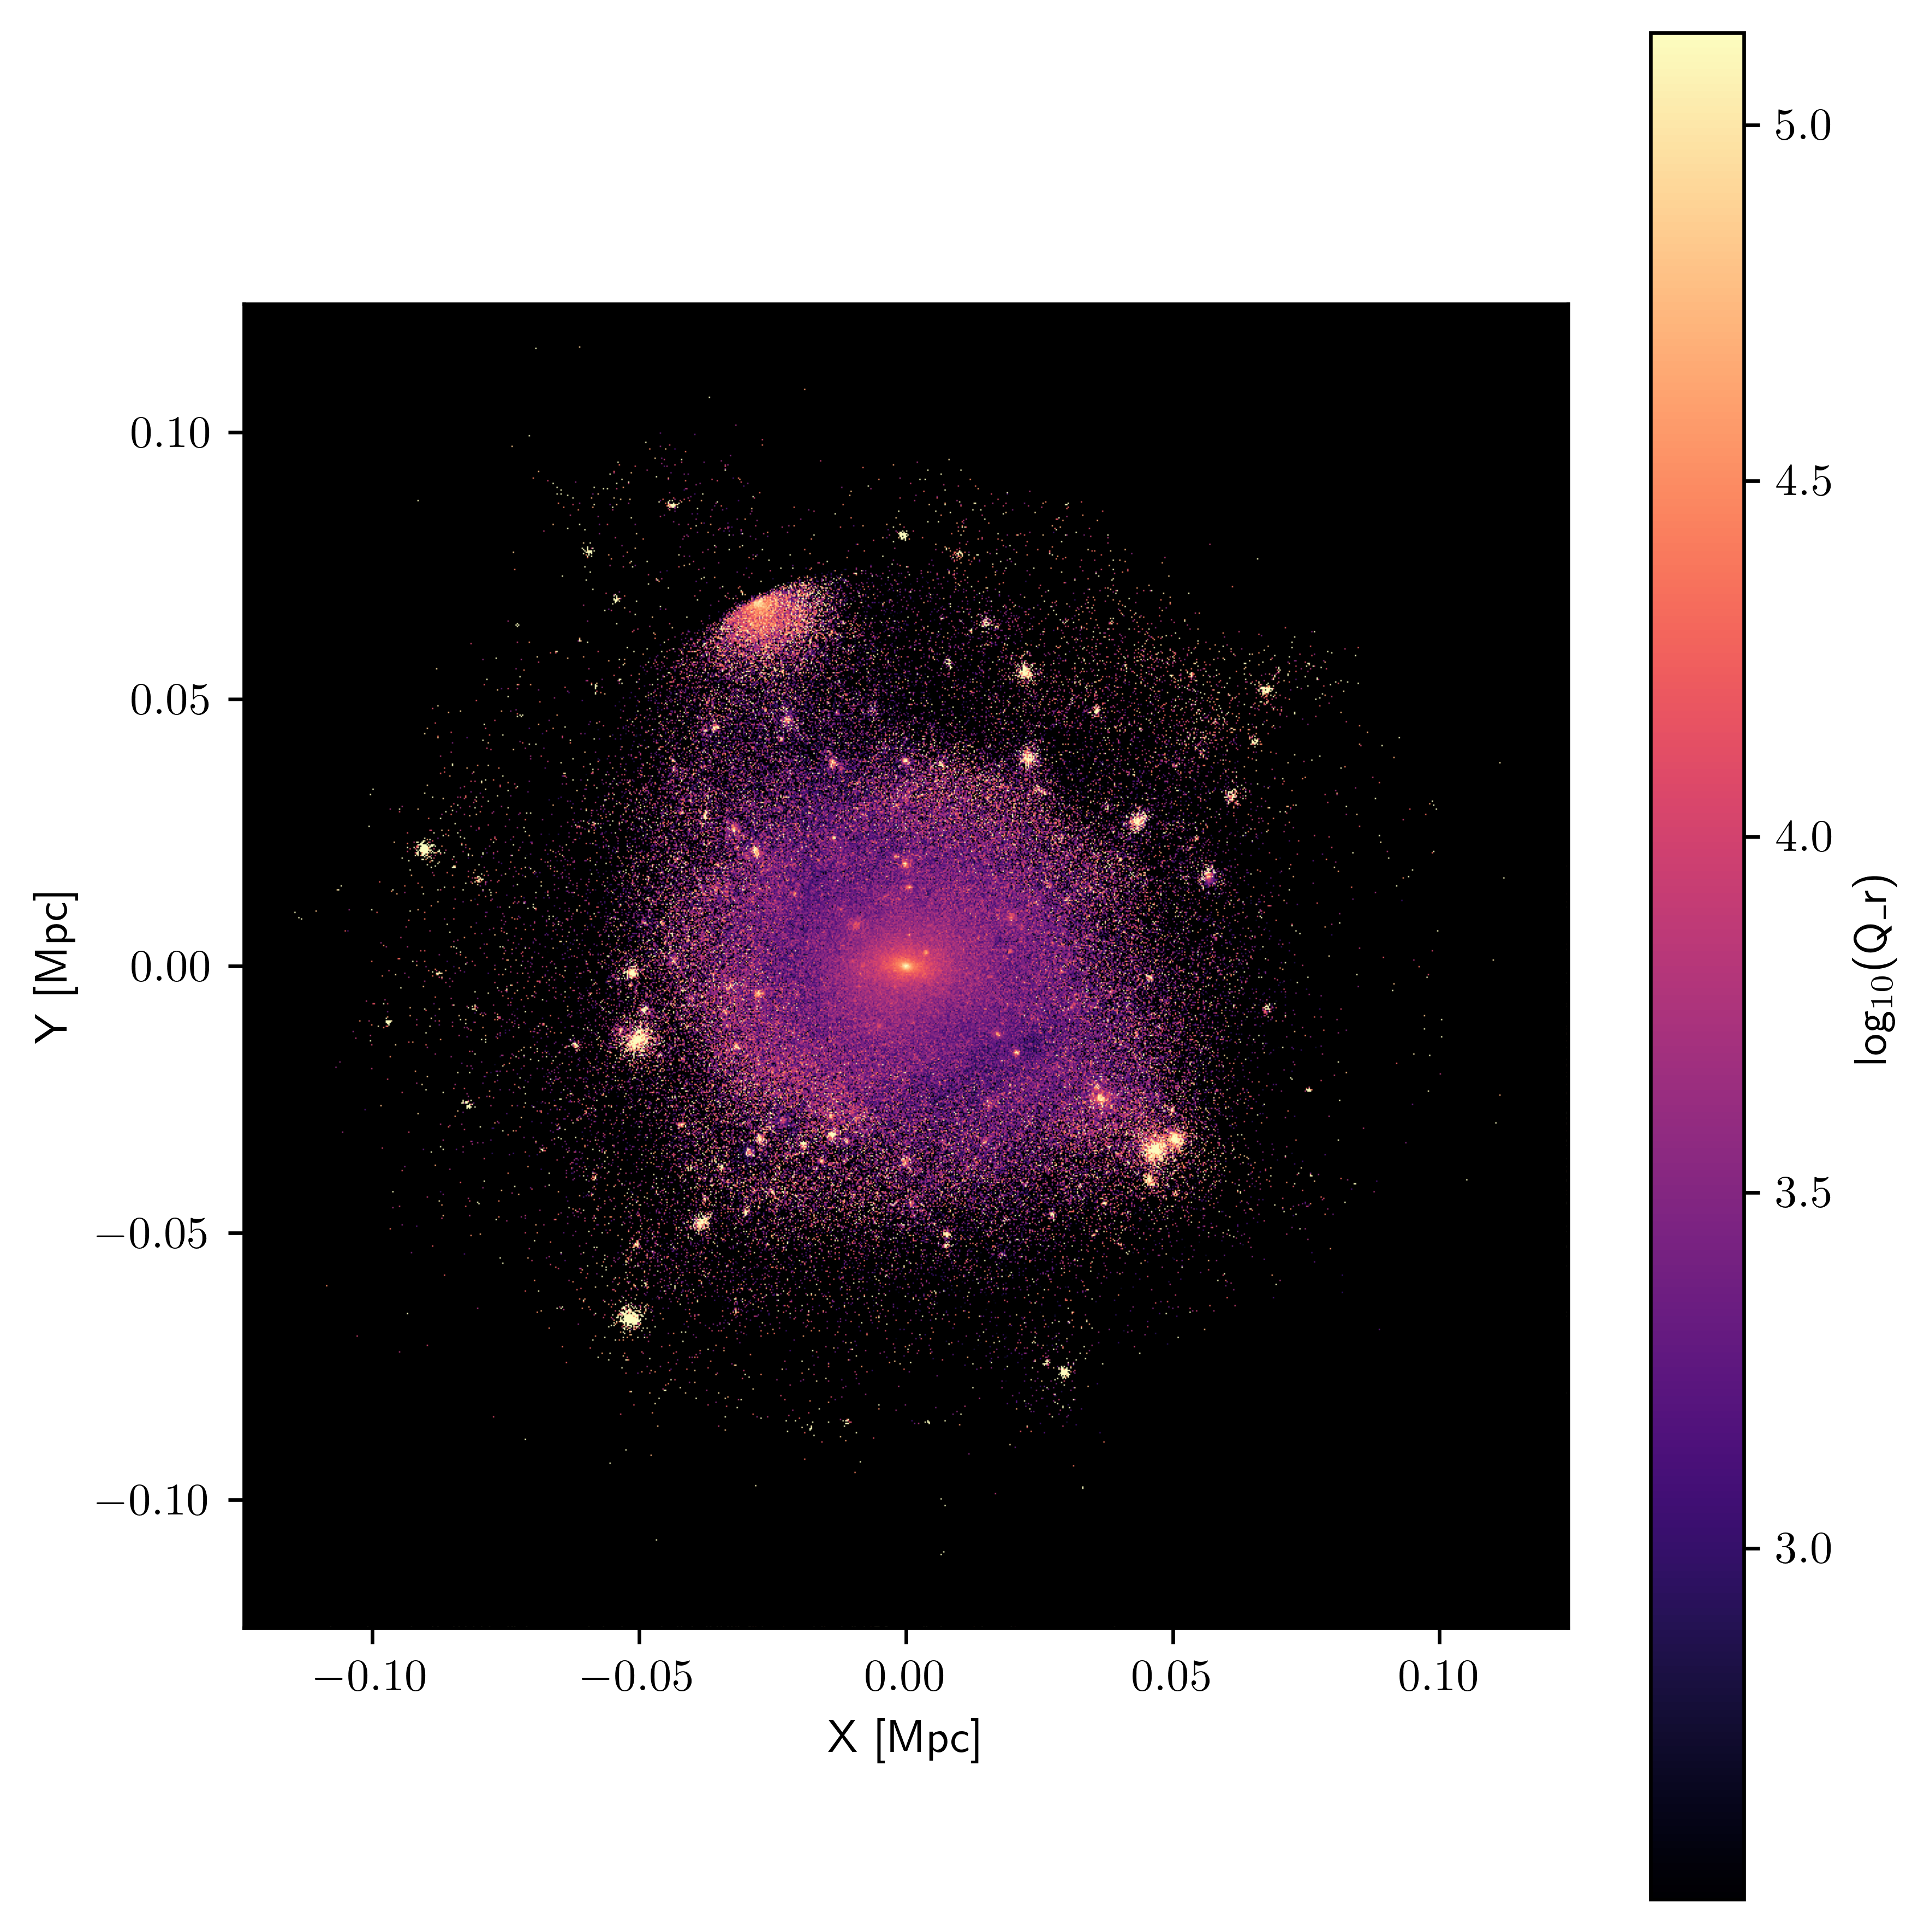

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import symlib
import numpy.ma as ma
from astropy.stats import sigma_clip

def visualize_projected_ppsd(
    suite_name,
    halo_id,
    input_dir,
    box_size=0.2,
    grid_size=256,
    quantity="Q_r",  # or "Q_tot"
    snapshot=199
):

    # --- Load simulation data ---
    sim_dir = symlib.get_host_directory(input_dir, suite_name, halo_id)
    part = symlib.Particles(sim_dir)
    p = part.read(snapshot)

    # --- Host halo frame ---
    r, hist = symlib.read_rockstar(sim_dir)
    host = r[0, -1]

    center = host["x"][-1] * 1e-3     # [Mpc]
    v_host = host["v"][-1]            # [km/s]
    r_vir = host["rvir"] * 1e-3       # [Mpc]

    # --- Relative positions and velocities ---
    x = p[0]["x"] * 1e-3 - center     # [Mpc]
    v = p[0]["v"] - v_host            # [km/s]

    if box_size is None:
        box_size = 1*r_vir

    # --- Project to x–y plane ---
    x2d = x[:, :2]
    shifted = (x2d + box_size) / (2 * box_size)
    clipped = np.clip(shifted, 0, 1 - 1e-5)
    grid_idx = (clipped * grid_size).astype(int)

    shape = (grid_size, grid_size)
    count = np.zeros(shape)

    if quantity == "Q_tot":
        vx_sum = np.zeros(shape)
        vy_sum = np.zeros(shape)
        vz_sum = np.zeros(shape)
        vx2_sum = np.zeros(shape)
        vy2_sum = np.zeros(shape)
        vz2_sum = np.zeros(shape)

        for i in range(len(x)):
            xi, yi = grid_idx[i]
            vx, vy, vz = v[i]
            count[xi, yi] += 1
            vx_sum[xi, yi] += vx
            vy_sum[xi, yi] += vy
            vz_sum[xi, yi] += vz
            vx2_sum[xi, yi] += vx**2
            vy2_sum[xi, yi] += vy**2
            vz2_sum[xi, yi] += vz**2

        mean_vx = vx_sum / count
        mean_vy = vy_sum / count
        mean_vz = vz_sum / count
        sigma2_x = vx2_sum / count - mean_vx**2
        sigma2_y = vy2_sum / count - mean_vy**2
        sigma2_z = vz2_sum / count - mean_vz**2
        sigma_tot = np.sqrt(sigma2_x + sigma2_y + sigma2_z)

        cell_area = (2 * box_size / grid_size)**2
        rho = count / cell_area
        Q = rho / sigma_tot**3
        Q[(count == 0) | (~np.isfinite(Q))] = np.nan

    elif quantity == "Q_r":
        vr_sum = np.zeros(shape)
        vr2_sum = np.zeros(shape)

        for i in range(len(x)):
            xi, yi = grid_idx[i]
            r_hat = x[i] / np.linalg.norm(x[i])
            vr = np.dot(v[i], r_hat)
            count[xi, yi] += 1
            vr_sum[xi, yi] += vr
            vr2_sum[xi, yi] += vr**2

        mean_vr = vr_sum / count
        sigma2_r = vr2_sum / count - mean_vr**2
        sigma_r = np.sqrt(sigma2_r)

        cell_area = (2 * box_size / grid_size)**2
        rho = count / cell_area
        Q = rho / sigma_r**3
        Q[(count == 0) | (~np.isfinite(Q))] = np.nan
        min_count = 3
        Q[count < min_count] = np.nan

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
    qlog = ma.masked_invalid(np.log10(Q))
    qlog_clipped = sigma_clip(qlog, sigma=5, masked=True)
    cmap = plt.get_cmap("magma").copy()
    cmap.set_bad(color="black") 
    im = ax.imshow(
        qlog_clipped.T, origin="lower",
        extent=[-box_size, box_size, -box_size, box_size],
        cmap=cmap, vmin = np.nanpercentile(qlog_clipped.data, 1), vmax = np.nanpercentile(qlog_clipped.data, 95)
    )

    # Labels and legend
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"log$_{10}$(%s)" % quantity)
    ax.set_xlabel("X [Mpc]")
    ax.set_ylabel("Y [Mpc]")
    ax.legend(loc="lower right", fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()

visualize_projected_ppsd(
    suite_name="SymphonyLMC",
    halo_id=3,
    input_dir="/Volumes/Atlas/Symphony",
    box_size=None,
    grid_size=1000,
    quantity="Q_r",
    snapshot=199)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial import cKDTree
from scipy.stats import binned_statistic_2d
import pandas as pd
import os
import symlib

def visualize_adaptive_projected_ppsd(
    suite_name,
    halo_id,
    input_dir,
    base_dir=None,
    box_size=None,
    quantity="Q_r",
    snapshot=199,
    n_neighbors=10,
    grid_res=2000
):
    # --- Halo ID as zero-padded string ---
    halo_id_str = f"{halo_id:03d}"

    # --- Load particle data ---
    sim_dir = symlib.get_host_directory(input_dir, suite_name, halo_id)
    part = symlib.Particles(sim_dir)
    p = part.read(snapshot)

    # --- Host halo data ---
    r_data, hist = symlib.read_rockstar(sim_dir)
    host = r_data[0, -1]
    center = host["x"][-1] * 1e-3  # Mpc
    v_host = host["v"][-1] 
    r_vir = host["rvir"] * 1e-3    # Mpc

    # --- Relative position & velocity ---
    x = p[0]["x"] * 1e-3 - center  # Mpc
    v = p[0]["v"] - v_host         # km/s

    # --- Compute 2D radius ---
    x2d = x[:, :2]
    r_2d = np.linalg.norm(x2d, axis=1)

    # --- Build KDTree in 2D ---
    tree = cKDTree(x2d)
    dist, idx = tree.query(x2d, k=n_neighbors)

    rho = np.zeros(len(x))
    sigma = np.zeros(len(x))

    for i in range(len(x)):
        neighbors = idx[i]
        v_neighbors = v[neighbors]
        rho[i] = n_neighbors / (np.pi * dist[i, -1]**2)  # in Mpc^-2

        if quantity == "Q_tot":
            v2 = np.sum((v_neighbors - np.mean(v_neighbors, axis=0))**2, axis=1)
            sigma[i] = np.sqrt(np.mean(v2))
        elif quantity == "Q_r":
            r_hat = x[i] / np.linalg.norm(x[i])
            v_radial = np.dot(v_neighbors, r_hat)
            sigma[i] = np.std(v_radial)

    # --- Compute Q ---
    Q = rho / sigma**3  # [Mpc^-2] / [km/s]^3
    Q *= 1e-6            # Convert rho from Mpc^-2 to kpc^-2
    Q[~np.isfinite(Q)] = np.nan
    logQ = np.log10(Q)

    # --- Bin into 2D image grid ---
    if box_size is None:
        box_size = r_vir
    x_plot = x[:, 0]
    y_plot = x[:, 1]
    mask = (np.abs(x_plot) < box_size) & (np.abs(y_plot) < box_size)

    H, xedges, yedges, _ = binned_statistic_2d(
        x_plot[mask], y_plot[mask], logQ[mask],
        statistic="mean", bins=grid_res
    )

    # --- Load halo metadata if base_dir is provided ---
    cvir, gamma, mvir = None, None, None
    if base_dir is not None:
        df_cvir  = pd.read_csv(os.path.join(base_dir, "output", suite_name, "halo_concentrations.csv"), dtype={"halo_id": str})
        df_gamma = pd.read_csv(os.path.join(base_dir, "output", suite_name, "accretion_rates.csv"),    dtype={"halo_index": str})
        df_mass  = pd.read_csv(os.path.join(base_dir, "output", suite_name, "halo_mass.csv"),          dtype={"halo_id": str})

        cvir  = float(df_cvir.loc[df_cvir["halo_id"] == halo_id_str, "cvir"].values[0])
        gamma = float(df_gamma.loc[df_gamma["halo_index"] == halo_id_str, "gamma"].values[0])
        mvir  = float(df_mass.loc[df_mass["halo_id"] == halo_id_str, "mvir"].values[0])

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
    plt.rcParams['text.usetex'] = True
    cmap = plt.get_cmap("magma").copy()
    cmap.set_bad(color="black")

    im = ax.imshow(
        H.T,
        extent=[-box_size, box_size, -box_size, box_size],
        origin="lower", cmap=cmap,
        vmin=np.nanpercentile(H, 1), vmax=np.nanpercentile(H, 99)
    )

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$\log_{10} \left[ Q~(\mathrm{M}_\odot~\mathrm{kpc}^{-2}~(\mathrm{km/s})^{-3}) \right]$", fontsize=14)

    circle = mpatches.Circle((0, 0), r_vir, edgecolor='white', facecolor='none',
                             linestyle='dotted', linewidth=1.2)
    ax.add_patch(circle)

    ax.set_xlabel(r"$X~[\mathrm{Mpc}]$", fontsize=16)
    ax.set_ylabel(r"$Y~[\mathrm{Mpc}]$", fontsize=16)

    title = f"{suite_name} – Halo {halo_id_str}"
    if cvir is not None and gamma is not None and mvir is not None:
        title += "\n" + rf"$c={cvir:.1f},\ \Gamma={gamma:.1e},\ M_{{vir}}={mvir:.1e}\ M_\odot$"

    ax.set_title(title, fontsize=14)
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

visualize_adaptive_projected_ppsd(
    suite_name="SymphonyLMC",
    halo_id=23,
    input_dir="/Volumes/Atlas/Symphony",
    base_dir="/Users/fengbocheng/Projects/Symphony-PPSD",
    box_size=None,
    quantity="Q_r",
    snapshot=199,
    grid_res=2000,
    n_neighbors=20)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial import cKDTree
from scipy.stats import binned_statistic_2d
import pandas as pd
import os
import symlib

def visualize_adaptive_projected_ppsd(
    suite_name,
    halo_id,
    input_dir,
    base_dir=None,
    box_size=None,
    quantity="Q_r",
    snapshot=199,
    n_neighbors=10,
    grid_res=2000,
    slice_thickness=0.02  # [Mpc], thin slice in Z-direction
):
    halo_id_str = f"{halo_id:03d}"

    sim_dir = symlib.get_host_directory(input_dir, suite_name, halo_id)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h  # Particle mass [Msun]
    part = symlib.Particles(sim_dir)
    p = part.read(snapshot)

    r_data, hist = symlib.read_rockstar(sim_dir)
    host = r_data[0, -1]
    center = host["x"][-1] * 1e-3  # Mpc
    v_host = host["v"][-1]
    r_vir = host["rvir"] * 1e-3    # Mpc

    x = p[0]["x"] * 1e-3 - center  # Mpc
    v = p[0]["v"] - v_host         # km/s

    # --- Apply slice in Z direction ---
    z_mask = np.abs(x[:, 2]) < slice_thickness / 2
    x = x[z_mask]
    v = v[z_mask]

    # --- Build 3D KDTree ---
    tree = cKDTree(x)
    dist, idx = tree.query(x, k=n_neighbors)

    rho = np.zeros(len(x))
    sigma = np.zeros(len(x))

    for i in range(len(x)):
        neighbors = idx[i]
        v_neighbors = v[neighbors]
        rho[i] = n_neighbors * mp / ((4/3) * np.pi * dist[i, -1]**3)  # Mpc^-3

        if quantity == "Q_tot":
            v2 = np.sum((v_neighbors - np.mean(v_neighbors, axis=0))**2, axis=1)
            sigma[i] = np.sqrt(np.mean(v2))
        elif quantity == "Q_r":
            r_hat = x[i] / np.linalg.norm(x[i])
            v_radial = np.dot(v_neighbors, r_hat)
            sigma[i] = np.std(v_radial)

    Q = rho / sigma**3
    Q *= 1e-9  # Convert rho from Mpc^-3 to kpc^-3
    Q[~np.isfinite(Q)] = np.nan
    logQ = np.log10(Q)

    if box_size is None:
        box_size = r_vir

    x_plot = x[:, 0]
    y_plot = x[:, 1]
    mask = (np.abs(x_plot) < box_size) & (np.abs(y_plot) < box_size)

    H, xedges, yedges, _ = binned_statistic_2d(
        x_plot[mask], y_plot[mask], logQ[mask],
        statistic="mean", bins=grid_res
    )

    cvir, gamma, mvir = None, None, None
    if base_dir is not None:
        df_cvir  = pd.read_csv(os.path.join(base_dir, "output", suite_name, "halo_concentrations.csv"), dtype={"halo_id": str})
        df_gamma = pd.read_csv(os.path.join(base_dir, "output", suite_name, "accretion_rates.csv"),    dtype={"halo_index": str})
        df_mass  = pd.read_csv(os.path.join(base_dir, "output", suite_name, "halo_mass.csv"),          dtype={"halo_id": str})

        cvir  = float(df_cvir.loc[df_cvir["halo_id"] == halo_id_str, "cvir"].values[0])
        gamma = float(df_gamma.loc[df_gamma["halo_index"] == halo_id_str, "gamma"].values[0])
        mvir  = float(df_mass.loc[df_mass["halo_id"] == halo_id_str, "mvir"].values[0])

    fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
    plt.rcParams['text.usetex'] = True
    cmap = plt.get_cmap("magma").copy()
    cmap.set_bad(color="black")

    im = ax.imshow(
        H.T,
        extent=[-box_size, box_size, -box_size, box_size],
        origin="lower", cmap=cmap,
        vmin=np.nanpercentile(H, 1), vmax=np.nanpercentile(H, 98)
    )

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$\log_{10} \left[ Q~(\mathrm{M}_\odot~\mathrm{kpc}^{-3}~(\mathrm{km/s})^{-3}) \right]$", fontsize=14)

    circle = mpatches.Circle((0, 0), r_vir, edgecolor='white', facecolor='none',
                             linestyle='dotted', linewidth=1.2)
    ax.add_patch(circle)

    ax.set_xlabel(r"$X~[\mathrm{Mpc}]$", fontsize=16)
    ax.set_ylabel(r"$Y~[\mathrm{Mpc}]$", fontsize=16)

    title = f"{suite_name} – Halo {halo_id_str}"
    if cvir is not None and gamma is not None and mvir is not None:
        title += "\n" + rf"$c={cvir:.1f},\ \Gamma={gamma:.1e}\ M_\odot / Gyr,\ M_{{vir}}={mvir:.1e}\ M_\odot$"

    ax.set_title(title, fontsize=12)
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

visualize_adaptive_projected_ppsd(
    suite_name="SymphonyCluster",
    halo_id=1,
    input_dir="/Volumes/Expansion/Symphony",
    base_dir="/Users/fengbocheng/Projects/Symphony-PPSD",
    box_size=None,
    quantity="Q_r",
    snapshot=199,
    grid_res=2000,
    n_neighbors=20,
    slice_thickness=1)

In [193]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import os

def const_model(r, a):
    return a * np.ones_like(r)

def print_bestfit_slope_for_halo(
    base_dir,
    suite_name,
    halo_id,
    r_fit_range=(0.01, 1.0)
):
    slope_path = os.path.join(
        base_dir, "output", suite_name, "ppsd_slope_profiles_r",
        f"halo_{int(halo_id):03d}_profile.csv"
    )

    if not os.path.exists(slope_path):
        print(f"[Error] File not found: {slope_path}")
        return None

    df = pd.read_csv(slope_path)
    r = pd.to_numeric(df["r_scaled"], errors="coerce").to_numpy(float)
    s = pd.to_numeric(df["slope_Q_r"], errors="coerce").to_numpy(float)

    mask = (r >= r_fit_range[0]) & (r <= r_fit_range[1]) & np.isfinite(s)
    if mask.sum() < 5:
        print(f"[Warning] Not enough data points in fit range for halo {halo_id}")
        return None

    r_fit, s_fit = r[mask], s[mask]

    try:
        popt, _ = curve_fit(const_model, r_fit, s_fit, p0=[np.median(s_fit)])
        best_slope = popt[0]
        print(f"[Result] Best-fitted slope for {suite_name}, halo {halo_id:03d} in r ∈ [{r_fit_range[0]}, {r_fit_range[1]}]: {best_slope:.4f}")
        return best_slope
    except Exception as e:
        print(f"[Error] Fitting failed: {e}")
        return None
    
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
for i in range(70):
    print_bestfit_slope_for_halo(base_dir, "SymphonyLMC", i, r_fit_range=(6e-3, 1.1))

[Result] Best-fitted slope for SymphonyLMC, halo 000 in r ∈ [0.006, 1.1]: -2.0254
[Result] Best-fitted slope for SymphonyLMC, halo 001 in r ∈ [0.006, 1.1]: -1.9147
[Result] Best-fitted slope for SymphonyLMC, halo 002 in r ∈ [0.006, 1.1]: -1.8711
[Result] Best-fitted slope for SymphonyLMC, halo 003 in r ∈ [0.006, 1.1]: -1.9041
[Result] Best-fitted slope for SymphonyLMC, halo 004 in r ∈ [0.006, 1.1]: -1.9066
[Result] Best-fitted slope for SymphonyLMC, halo 005 in r ∈ [0.006, 1.1]: -1.7941
[Result] Best-fitted slope for SymphonyLMC, halo 006 in r ∈ [0.006, 1.1]: -1.9546
[Result] Best-fitted slope for SymphonyLMC, halo 007 in r ∈ [0.006, 1.1]: -1.7848
[Result] Best-fitted slope for SymphonyLMC, halo 008 in r ∈ [0.006, 1.1]: -1.8014
[Result] Best-fitted slope for SymphonyLMC, halo 009 in r ∈ [0.006, 1.1]: -1.7726
[Result] Best-fitted slope for SymphonyLMC, halo 010 in r ∈ [0.006, 1.1]: -1.8074
[Result] Best-fitted slope for SymphonyLMC, halo 011 in r ∈ [0.006, 1.1]: -1.7680
[Result] Best-fi

[Result] Best-fitted slope for SymphonyCluster, halo 033 in r ∈ [0.005, 1.2]: -2.0950
[Result] Best-fitted slope for SymphonyCluster, halo 021 in r ∈ [0.005, 1.2]: -2.2441
[Result] Best-fitted slope for SymphonyCluster, halo 045 in r ∈ [0.005, 1.2]: -2.0317
[Result] Best-fitted slope for SymphonyCluster, halo 062 in r ∈ [0.005, 1.2]: -2.0027
[Result] Best-fitted slope for SymphonyCluster, halo 063 in r ∈ [0.005, 1.2]: -2.0497
[Result] Best-fitted slope for SymphonyCluster, halo 064 in r ∈ [0.005, 1.2]: -1.9884
[Result] Best-fitted slope for SymphonyCluster, halo 067 in r ∈ [0.005, 1.2]: -2.0195